# BERT

The transformer model originally has been developed with a focus on language translation. However, its architecture has been used for many different models
that differ in the way which parts of the transformer are used and which training objective is used for parameter calibration. A popular model with this respect is the BERT model which stands for Bidirectional Encoder Representations from Transformers. The original paper can be found [here](https://arxiv.org/abs/1810.04805). Its architecture uses the encoder of the transformer, only, as illustrated in the picture below. Furthermore, it trains the positional embeddings instead of using the trigonometric functions as the transformer.

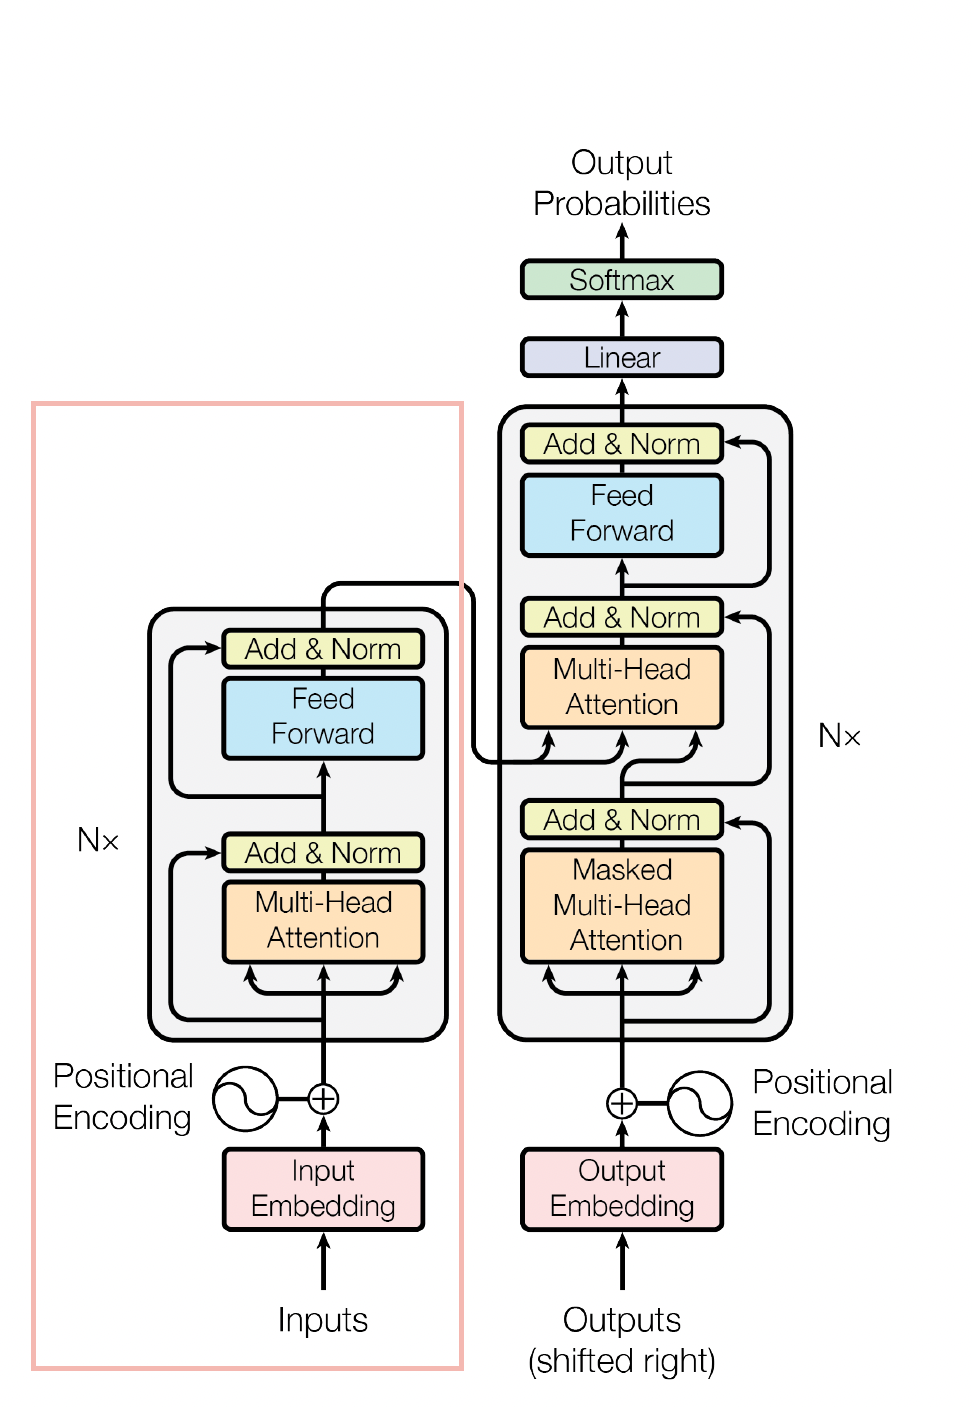

In [1]:
from IPython.display import Image
Image(filename='bert.png', width=400) 

One of the reasons for the popularity of the BERT model is its versatility which comes from the training routine of the model. The parameters of the model are first trained by pre-training which trains the model by two tasks: (1) Masked Language Modeling (MLM) and (2) Next Sentence Prediction (NSP). The aim for MLM is to predict missing words in a sentence. NSP aims to predict which sentences belong together. 

## Masked Language Modeling

To train bidirectional representations, a fraction of tokens from a sentence is masked and the corresponding embedding is used to predict the masked word. Let us take a look at an example in the cell below. First we import a BERT model which is used to encode the example sentences. The embedding dimension of the BERT model is 768. This means every token is represented by 768 numbers. Sentences need to be pre-processed in the same way as the original model has been trained. After pre-processing, we observe that a \[CLS\] and a \[SEP\] token is included in the beginning and the end of the sentence, respectively. We come to this at a later stage. With this pre-processed version, the sentence has length 11 which is why the output of the BERT model has dimension $11 \times 768$. Another important aspect is the the numerical representation of the same word differs w.r.t. to its context. This is demonstrated by taking a look at the first ten embedding numbers of the word *the* in the beginning and the end of the sentence. 

In [2]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

text = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
] 

encoded_input = tokenizer(text[0], return_tensors='pt')

with torch.inference_mode():
    output = model(**encoded_input)

line_split = '-'*100
print(f'\n Preprocessed example sentence number 1:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()])

print(f'\n Corresponding token ids:\n{line_split}')
print(encoded_input.input_ids.squeeze().tolist())

print(f'\n Shape of the BERT output for this sentence:\n{line_split}')
print(output.last_hidden_state.shape)

print(f'\n First ten embedding numbers for the word "the" in the sentence beginning:\n{line_split}')
print(output.last_hidden_state[0, 1, :10])

print(f'\n First ten embedding numbers for the word "the" in the sentence ending:\n{line_split}')
print(output.last_hidden_state[0, 8, :10])


 Preprocessed example sentence number 1:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich', '[SEP]']

 Corresponding token ids:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 2066, 1037, 3538, 1997, 1996, 11642, 102]

 Shape of the BERT output for this sentence:
----------------------------------------------------------------------------------------------------
torch.Size([1, 11, 768])

 First ten embedding numbers for the word "the" in the sentence beginning:
----------------------------------------------------------------------------------------------------
tensor([-0.2704, -0.1033,  0.3877, -0.3113,  0.6653,  0.6063, -0.1018,  0.4087,
         0.4454,  0.2812])

 First ten embedding numbers for the word "the" in the sentence ending:
---------------------------------------------

In the cell below we take a look at the same example, however, this time a few words are masked (randomly) with the masked token. The task is to predict with the mask embeddings the corresponding word correctly. To do so, we would extract the mask embeddings which are of dimension 768 and process the embedding through an output layer which generates probability predictions for every word in the lexicon. I.e., the BERT model shown below uses a dictionary with 30,522 tokens. This means every mask token is processed such that given this token at its specific position, we receive 30,522 probability predictions which model the probability that this masked token is one of the tokens out of the lexicon. The parameters of the model are updated using the cross entropy loss which means the masked language modeling approach is a multi-classification task. The original paper randomly pre-selects 15\% of the tokens in a sequence to be potentially masked, 80\% out of these tokens are replaced by the \[MASK\] token, 10 \% out of these tokens are replaced by other random tokens and 10\% out of these tokens are left as is.

In [3]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
] 

inputs = tokenizer(text, padding = True, return_tensors='pt')
inputs['labels'] = inputs.input_ids.detach().clone()

# create random array of floats in equal dimension to input_ids
torch.manual_seed(123)
rand = torch.rand(inputs.input_ids.shape)
# where the random array is less than 0.15, we set true
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
# apply selection index to inputs.input_ids, adding MASK tokens
inputs.input_ids[mask_arr] = 103

# pass inputs as kwarg to model
outputs = model(**inputs)

print(f'\n Preprocessed example sentence number 1 with masked words:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in inputs.input_ids[0].tolist()])
print(f'\n Corresponding token ids:\n{line_split}')
print(inputs.input_ids[0].squeeze().tolist())
print(f'\n Corresponding labels:\n{line_split}')
print(inputs.labels[0].squeeze().tolist())
print(f'\n Probability predictions for the first 20 words in the lexicon, given the first masked token:\n ')
print(torch.softmax(outputs.logits[0].view(-1, 30522), dim = 1)[4][:20].detach().numpy())

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 Preprocessed example sentence number 1 with masked words:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', '[MASK]', 'a', '[MASK]', '[MASK]', 'the', 'sandwich', '[SEP]']

 Corresponding token ids:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 103, 1037, 103, 103, 1996, 11642, 102]

 Corresponding labels:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 2066, 1037, 3538, 1997, 1996, 11642, 102]

 Probability predictions for the first 20 words in the lexicon, given the first masked token:
 
[9.79043406e-08 1.16180381e-07 9.52346539e-08 1.10266356e-07
 1.08428324e-07 1.06025531e-07 1.09137197e-07 1.16444149e-07
 9.25754122e-08 1.10625955e-07 1.11280080e-07 1.08806518e-07
 9.45591623e-08 1.20132810e-07 1.08166411e-07 8.49750634e-08
 1.04969438e-07 9.28

## Next sentence prediction

Next sentence prediction uses a separator token to mark individual sentences. During training, random examples are drawn in equal proportions. I.e., 50\% of the sentence pairs actually belong together and 50\% of the sentence pairs are random sentences merged together. The task becomes a binary prediction problem. The embedding of the \[CLS\] token is used to predict if the two sentences belong together or not. Similar for masked language modeling, the embedding of the \[CLS\] token is processed through an output layer which predicts probabilities for the sentences belonging together or not, respectively. Parameters are updated using the binary cross entropy loss. Category $0$ is used for sentences belonging together and $1$ for sentences belonging not together.

In [4]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

sentence_a = "The dog would like a piece of the sandwich."
sentence_b = "A dog is a good friend"
encoded_input = tokenizer(sentence_a, sentence_b, return_tensors='pt')

labels = torch.LongTensor([0])
outputs = model(**encoded_input, labels = labels)

print(f'\n Preprocessed example sentence number 1:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()])
print(f'\n The probabilitiy predictions that the sentences belong together or not: \n')
print(torch.softmax(outputs.logits.view(-1, 2), dim = 1).detach().numpy())


 Preprocessed example sentence number 1:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich', '.', '[SEP]', 'a', 'dog', 'is', 'a', 'good', 'friend', '[SEP]']

 The probabilitiy predictions that the sentences belong together or not: 

[[9.9999106e-01 8.9278019e-06]]


## Fine-tuning

The BERT model comes with great versatility because once it has been pre-trained, it can be used for downstream tasks which are used to fine-tune the model. For instance, if we want to build a financial sentiment classifier, we would use the \[CLS\] token embedding and process it trough an output layer which returns probabilities for each category, e.g., negative, neutral, positive. We could also use the \[CLS\] token and process it through an output layer with a single real-valued output value if our target would be, e.g., the financial stock return after the company's announcement whose text is used as input to the model. Given a specific task, all parameters of the model are trained w.r.t. to the task. This means, after successful pre-training, all embeddings are of high quality in terms of understanding the content of a text and its context. Starting with these parameters, we further fine-tune them such that the embeddings become better for the task at hand. One advantage of the fine-tuning approach is that smaller datasets suffice for successful training.

## Other BERT models



Since its introduction, different variants of the BERT model have been introduced, mostly with the aim to improve its performance:

* [RoBERTa](https://arxiv.org/abs/1907.11692): Modification of pre-training with improved performance on downstream tasks
* [DistilBERT](https://arxiv.org/abs/1910.01108): A smaller and faster version retaining most of the original model's performance.
* [ALBERT](https://arxiv.org/abs/1909.11942): Reduction of memory consumption and increase in training speed.

Besides these rather technical modifications, we also find domain specific BERT models in the area of financial markets, e.g., [FinBERT](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214) by Huang et al. (2022). They pre-train a standard BERT model on 10-K, 10-Q form filings (annual and quarter reports) of US companies, analyst reports and earning conference call transcripts. The demonstrate superior performance on sentiment and ESG classification tasks as stock market reaction assessment quantified by event returns of earning calls. Their results indicate that the model's superiority stems from the understanding of tokens which are of special relevance in the financial domain.